# Introduction to optimization

The basic components

* The objective function (also called the 'cost' function)

In [1]:
import numpy as np
objective = np.poly1d([1.3, 4.0, 0.6])
print objective

     2
1.3 x + 4 x + 0.6


* The "optimizer"

In [2]:
import scipy.optimize as opt
x_ = opt.fmin(objective, [3])
print "solved: x={}".format(x_)

Optimization terminated successfully.
         Current function value: -2.476923
         Iterations: 20
         Function evaluations: 40
solved: x=[-1.53845215]


In [3]:
%matplotlib inline

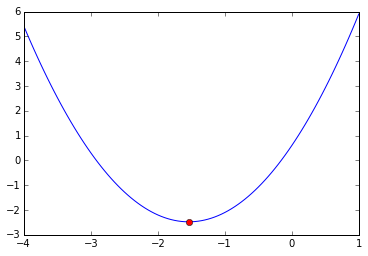

In [4]:
x = np.linspace(-4,1,101.)
import matplotlib.pylab as mpl
mpl.plot(x, objective(x))
mpl.plot(x_, objective(x_), 'ro')

Additional components

* "Box" constraints

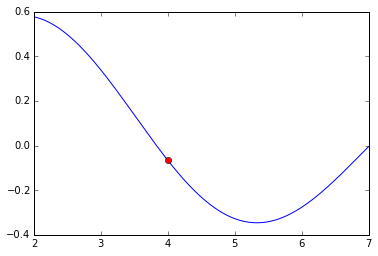

In [5]:
import scipy.special as ss
import scipy.optimize as opt
import numpy as np
import matplotlib.pylab as mpl

x = np.linspace(2, 7, 200)

# 1st order Bessel
j1x = ss.j1(x)
mpl.plot(x, j1x)

# use scipy.optimize's more modern "results object" interface
result = opt.minimize_scalar(ss.j1, method="bounded", bounds=[2, 4])

j1_min = ss.j1(result.x)
mpl.plot(result.x, j1_min,'ro')

* The gradient and/or hessian

In [6]:
import mystic.models as models
print(models.rosen.__doc__)

evaluates an N-dimensional Rosenbrock saddle for a list of coeffs

f(x) = \sum_(i=0)^(N-2) 100*(x_(i+1) - x_(i)^(2))^(2) + (1 - x_(i))^(2)

Inspect with mystic_model_plotter using::
    mystic.models.rosen -b "-3:3:.1, -1:5:.1, 1" -d -x 1

The minimum is f(x)=0.0 at x_i=1.0 for all i


In [9]:
!mystic_model_plotter.py mystic.models.rosen -f -d -x 1 -b "-3:3:.1, -1:5:.1, 1"

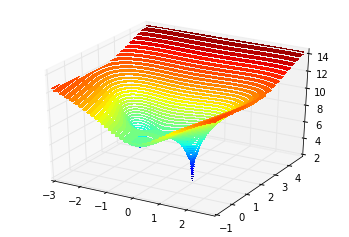

In [5]:
import mystic
mystic.model_plotter(mystic.models.rosen, fill=True, depth=True, scale=1, bounds="-3:3:.1, -1:5:.1, 1")

In [10]:
import scipy.optimize as opt
import numpy as np

# initial guess
x0 = [1.3, 1.6, -0.5, -1.8, 0.8]

result = opt.minimize(opt.rosen, x0)
print result.x

# number of function evaluations
print result.nfev

# again, but this time provide the derivative
result = opt.minimize(opt.rosen, x0, jac=opt.rosen_der)
print result.x

# number of function evaluations and derivative evaluations
print result.nfev, result.njev
print ''

# however, note for a different x0...
for i in range(5):
    x0 = np.random.randint(-20,20,5)
    result = opt.minimize(opt.rosen, x0, jac=opt.rosen_der)
    print "{} @ {} evals".format(result.x, result.nfev)

[ 0.9999992   0.99999842  0.99999685  0.99999371  0.99998742]
581
[ 1.          1.          1.          1.          1.00000001]
81 81

[-0.96205103  0.9357394   0.88071362  0.7778777   0.60509372] @ 86 evals
[ 0.99999998  0.99999997  0.99999993  0.99999987  0.99999975] @ 93 evals
[-0.96205101  0.93573938  0.88071356  0.77787762  0.6050936 ] @ 92 evals
[-0.96205102  0.93573939  0.8807136   0.77787767  0.60509366] @ 91 evals
[-0.96205102  0.9357394   0.88071361  0.77787769  0.6050937 ] @ 91 evals


* The penalty functions

$\psi(x) = f(x) + k*p(x)$

In [42]:
# http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#tutorial-sqlsp
'''
  Maximize: f(x) = 2*x0*x1 + 2*x0 - x0**2 - 2*x1**2
  
  Subject to:    x0**3 - x1 == 0
                         x1 >= 1
'''
import numpy as np

def objective(x, sign=1.0):
    return sign*(2*x[0]*x[1] + 2*x[0] - x[0]**2 - 2*x[1]**2)

def derivative(x, sign=1.0):
    dfdx0 = sign*(-2*x[0] + 2*x[1] + 2)
    dfdx1 = sign*(2*x[0] - 4*x[1])
    return np.array([ dfdx0, dfdx1 ])

# unconstrained
result = opt.minimize(objective, [-1.0,1.0], args=(-1.0,),
                      jac=derivative, method='SLSQP', options={'disp': True})
print("unconstrained: {}".format(result.x))


cons = ({'type': 'eq',
         'fun' : lambda x: np.array([x[0]**3 - x[1]]),
         'jac' : lambda x: np.array([3.0*(x[0]**2.0), -1.0])},
        {'type': 'ineq',
         'fun' : lambda x: np.array([x[1] - 1]),
         'jac' : lambda x: np.array([0.0, 1.0])})

# constrained
result = opt.minimize(objective, [-1.0,1.0], args=(-1.0,), jac=derivative,
                      constraints=cons, method='SLSQP', options={'disp': True})

print("constrained: {}".format(result.x))

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -2.0
            Iterations: 4
            Function evaluations: 5
            Gradient evaluations: 4
unconstrained: [ 2.  1.]
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -1.00000018311
            Iterations: 9
            Function evaluations: 14
            Gradient evaluations: 9
constrained: [ 1.00000009  1.        ]


Optimizer classifications

* Constrained versus unconstrained (and importantly LP and QP)

In [49]:
import scipy.optimize as opt

# constrained: linear (i.e. A*x + b)
print opt.cobyla.fmin_cobyla
print opt.linprog

# constrained: quadratic programming  (i.e. up to x**2)
print opt.fmin_slsqp

<function fmin_cobyla at 0x112c29758>
<function linprog at 0x113f24398>
<function fmin_slsqp at 0x112c299b0>


In [47]:
# http://cvxopt.org/examples/tutorial/lp.html
'''
minimize:  f = 2*x0 + x1

subject to:
           -x0 + x1 <= 1
            x0 + x1 >= 2
            x1 >= 0
            x0 - 2*x1 <= 4
'''

import cvxopt as cvx
from cvxopt import solvers as cvx_solvers

A = cvx.matrix([ [-1.0, -1.0, 0.0, 1.0], [1.0, -1.0, -1.0, -2.0] ])
b = cvx.matrix([ 1.0, -2.0, 0.0, 4.0 ])
cost = cvx.matrix([ 2.0, 1.0 ])
sol = cvx_solvers.lp(cost, A, b)

print(sol['x'])

     pcost       dcost       gap    pres   dres   k/t
 0:  2.6471e+00 -7.0588e-01  2e+01  8e-01  2e+00  1e+00
 1:  3.0726e+00  2.8437e+00  1e+00  1e-01  2e-01  3e-01
 2:  2.4891e+00  2.4808e+00  1e-01  1e-02  2e-02  5e-02
 3:  2.4999e+00  2.4998e+00  1e-03  1e-04  2e-04  5e-04
 4:  2.5000e+00  2.5000e+00  1e-05  1e-06  2e-06  5e-06
 5:  2.5000e+00  2.5000e+00  1e-07  1e-08  2e-08  5e-08
Optimal solution found.
[ 5.00e-01]
[ 1.50e+00]



In [48]:
# http://cvxopt.org/examples/tutorial/qp.html
'''
minimize:  f = 2*x1**2 + x2**2 + x1*x2 + x1 + x2

subject to:
            x1 >= 0
            x2 >= 0
            x1 + x2 == 1
'''

import cvxopt as cvx
from cvxopt import solvers as cvx_solvers

Q = 2*cvx.matrix([ [2, .5], [.5, 1] ])
p = cvx.matrix([1.0, 1.0])
G = cvx.matrix([[-1.0,0.0],[0.0,-1.0]])
h = cvx.matrix([0.0,0.0])
A = cvx.matrix([1.0, 1.0], (1,2))
b = cvx.matrix(1.0)
sol = cvx_solvers.qp(Q, p, G, h, A, b)

print(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  1.8889e+00  7.7778e-01  1e+00  2e-16  2e+00
 1:  1.8769e+00  1.8320e+00  4e-02  0e+00  6e-02
 2:  1.8750e+00  1.8739e+00  1e-03  1e-16  5e-04
 3:  1.8750e+00  1.8750e+00  1e-05  6e-17  5e-06
 4:  1.8750e+00  1.8750e+00  1e-07  2e-16  5e-08
Optimal solution found.
[ 2.50e-01]
[ 7.50e-01]



Notice how much nicer it is to see the optimizer "trajectory".  Now, instead of a single number, we have the path the optimizer took. `scipy.optimize` has a version of this, with `options={'retall':True}`, which returns the solver trajectory.

**EXERCISE:** Solve the constrained programming problem by any of the means above.

Minimize: f = -1*x[0] + 4*x[1]

Subject to: -3*x[0] + 1*x[1] <= 6
             1*x[0] + 2*x[1] <= 4
                        x[1] >= -3

where:  -inf <= x[0] <= inf

* Local versus global

In [50]:
import scipy.optimize as opt

# probabilstic solvers, that use random hopping/mutations
print opt.differential_evolution
print opt.basinhopping
print opt.anneal

<function differential_evolution at 0x113f245f0>
<function basinhopping at 0x113f16488>
<function anneal at 0x112c29320>


In [12]:
import scipy.optimize as opt

# bounds instead of an initial guess
bounds = [(-10., 10)]*5

for i in range(10):
    result = opt.differential_evolution(opt.rosen, bounds)
    print result.x,

    # number of function evaluations
    print '@ {} evals'.format(result.nfev)

[ 1.  1.  1.  1.  1.] @ 30306 evals
[ 1.  1.  1.  1.  1.] @ 27981 evals
[-0.96197616  0.93559583  0.88044541  0.777405    0.60435632] @ 7104 evals
[ 1.  1.  1.  1.  1.] @ 27456 evals
[ 1.  1.  1.  1.  1.] @ 27006 evals
[ 1.  1.  1.  1.  1.] @ 29106 evals
[ 1.  1.  1.  1.  1.] @ 26481 evals
[ 1.  1.  1.  1.  1.] @ 28056 evals
[ 1.  1.  1.  1.  1.] @ 29256 evals
[ 1.  1.  1.  1.  1.] @ 27231 evals


* Gradient descent and steepest descent

* Genetic and stochastic

* Not covered: other exotic types

Other important special cases:

* Least-squares fitting

target parameters: [3, 2, 1, 0.7853981633974483]
solved parameters: [ 2.99399187  1.99439132  1.01332     0.73520273]
covarance: [ 0.07289366  0.00803201  0.00076332  0.01177825]


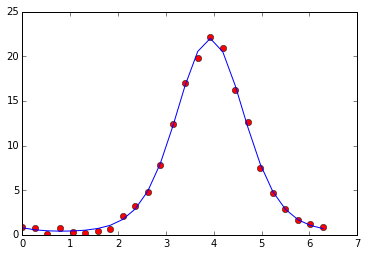

In [79]:
import scipy.optimize as opt
import scipy.stats as stats
import numpy as np

# Define the function to fit.
def function(x, a, b, f, phi):
    result = a * np.exp(-b * np.sin(f * x + phi))
    return result

# Create a noisy data set around the actual parameters
true_params = [3, 2, 1, np.pi/4]
print "target parameters: {}".format(true_params)
x = np.linspace(0, 2*np.pi, 25)
exact = function(x, *true_params)
noisy = exact + 0.3*stats.norm.rvs(size=len(x))

# Use curve_fit to estimate the function parameters from the noisy data.
initial_guess = [1,1,1,1]
estimated_params, err_est = opt.curve_fit(function, x, noisy, p0=initial_guess)
print "solved parameters: {}".format(estimated_params)

# err_est is an estimate of the covariance matrix of the estimates
print "covarance: {}".format(err_est.diagonal())

import matplotlib.pylab as mpl
mpl.plot(x, noisy, 'ro')
mpl.plot(x, function(x, *estimated_params)) 

* Not Covered: integer programming

Typical uses

* Function minimization

* Data fitting

* Root finding

In [82]:
import numpy as np
import scipy.optimize as opt

def system(x,a,b,c):
    x0, x1, x2 = x
    eqs= [
        3 * x0 - np.cos(x1*x2) + a, # == 0
        x0**2 - 81*(x1+0.1)**2 + np.sin(x2) + b, # == 0
        np.exp(-x0*x1) + 20*x2 + c # == 0
    ]
    return eqs


# coefficients
a = -0.5
b = 1.06
c = (10 * np.pi - 3.0) / 3

# initial guess
x0 = [0.1, 0.1, -0.1]

# Solve the system of non-linear equations.
result = opt.root(system, x0, args=(a, b, c))
print "root:", result.x
print "solution:", result.fun

root: [  5.00000000e-01   1.38102142e-13  -5.23598776e-01]
solution: [  0.00000000e+00  -2.23110419e-12   7.46069873e-14]


* Parameter estimation

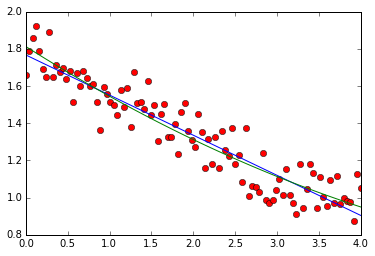

In [91]:
import numpy as np
import scipy.stats as stats

# Create clean data.
x = np.linspace(0, 4.0, 100)
y = 1.5 * np.exp(-0.2 * x) + 0.3

# Add a bit of noise.
noise = 0.1 * stats.norm.rvs(size=100)
noisy_y = y + noise

# Fit noisy data with a linear model.
linear_coef = np.polyfit(x, noisy_y, 1)
linear_poly = np.poly1d(linear_coef)
linear_y = linear_poly(x)

# Fit noisy data with a quadratic model.
quad_coef = np.polyfit(x, noisy_y, 2)
quad_poly = np.poly1d(quad_coef)
quad_y = quad_poly(x)

import matplotlib.pylab as mpl
mpl.plot(x, noisy_y, 'ro')
mpl.plot(x, linear_y)
mpl.plot(x, quad_y)
#mpl.plot(x, y)

Standard diagnostic tools

* Eyeball the plotted solution against the objective

* Run several times and take the best result

* Log of intermediate results, per iteration

* Rare: look at the covariance matrix

* Issue: how can you really be sure you have the results you were looking for?

**EXERCISE:** Use any of the solvers we've seen thus far to find the minimum of the `zimmermann` function (i.e. use `mystic.models.zimmermann` as the objective).  Use the bounds suggested below, if your choice of solver allows it.

In [93]:
import mystic.models as models
print models.zimmermann.__doc__

evaluates a Zimmermann function for a list of coeffs

f(x) = max(f_0(x), p_i(x)), with i = 0,1,2,3

Where:
f_0(x) = 9 - x_0 - x_1
with for x_0 < 0:
p_0(x) = -100 * x_0
and for x_1 < 0:
p_1(x) = -100 * x_1
and for c_2(x) > 16 and c_3(x) > 14:
p_i(x) = 100 * c_i(x), with i = 2,3
c_2(x) = (x_0 - 3)^2 + (x_1 - 2)^2
c_3(x) = x_0 * x_1
Otherwise, p_i(x)=0 for i=0,1,2,3 and c_i(x)=0 for i=2,3.

Inspect with mystic_model_plotter using::
    mystic.models.zimmermann -b "-5:10:.1, -5:10:.1" -d -x 1

The minimum is f(x)=0.0 at x=(7.0,2.0)


**EXERCISE:** Do the same for the `fosc3d` function found at `mystic.models.fosc3d`, using the bounds suggested by the documentation, if your chosen solver accepts bounds or constraints.

More to ponder: what about high-dimenstional and nonlinear constraints?

Let's look at optimization "redesigned" in [mystic](mystic.ipynb)...